This notebook will explore an alternative to measuring effective radii of galaxies to compare size ratio distributions. 

In [10]:
import numpy as np
import sys

from astropy.table import Table
from astropy.io import fits
from astropy.visualization import simple_norm

from scipy.stats import scoreatpercentile

#for smoothing the images...I think
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.modeling import models, fitting

from matplotlib import pyplot as plt
%matplotlib inline

import os
homedir = os.getenv("HOME")

sys.path.append(homedir+'/github/halphagui/')
from photwrapper import ellipse
from photwrapper import display_image

In [18]:
#test galaxy (VFID0901 --> NGC3683)
#cutout images
w1_im = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W1.fits')
w3_im = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W3.fits')

#psf images
w1_psf = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-psf-W1.fits')
w3_psf = fits.getdata(homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-psf-W3.fits')

## Convolve W1 image using Gaussian fits

In [19]:
fit_t = fitting.LevMarLSQFitter()

amp_w1 = np.max(w1_psf)
#sigma = np.std(w1_psf)
sigma = 3     #resulting model STD is too infinitesimal otherwise. Choose a somewhat arbitrary sigma to start.
y_max_w1, x_max_w1 = w1_psf.shape

#set up symmetric model
g2_w1 = models.Gaussian2D(amp_w1, x_max_w1/2, y_max_w1/2, sigma, sigma)

#define indices on a grid corresponding to pixel coordinates
yi_w1, xi_w1 = np.indices(w1_psf.shape)

#fitting of model g2 to the W1 PSF
g_w1 = fit_t(g2_w1, xi_w1, yi_w1, w1_psf)

#same sigma as above, so no need to redefine variable
amp_w3 = np.max(w3_psf)
#redefined in case shapes are different
y_max_w3, x_max_w3 = w3_psf.shape

g2_w3 = models.Gaussian2D(amp_w3, x_max_w3/2, y_max_w3/2, sigma, sigma)

yi_w3, xi_w3 = np.indices(w3_psf.shape)

#fitting of model g2 to the W3 PSF
g_w3 = fit_t(g2_w3, xi_w3, yi_w3, w3_psf)

In [20]:
#but I would still like to extract the x- and y- STDDEVs of the residual, just because.
#note --> STDDEVs add in quadrature.
sig_kernelx = np.sqrt(g_w3.x_stddev[0]**2 - g_w1.x_stddev[0]**2)
sig_kernely = np.sqrt(g_w3.y_stddev[0]**2 - g_w1.y_stddev[0]**2)

In [21]:
smoothed_w1 = convolve(w1_im, Gaussian2DKernel(x_stddev=sig_kernelx, y_stddev=sig_kernely, theta=0.0))

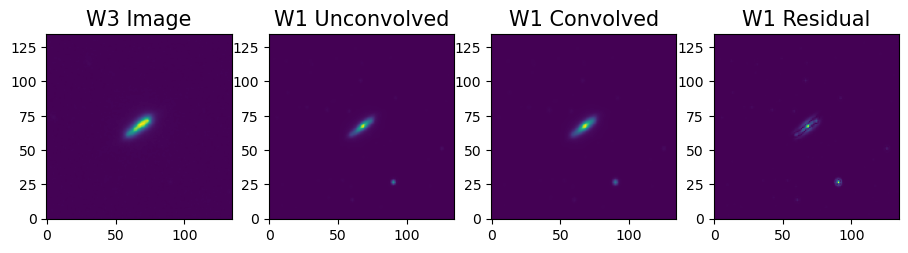

In [22]:
images = [w3_im,w1_im,smoothed_w1,np.abs(smoothed_w1-w1_im)]
titles = ['W3 Image','W1 Unconvolved','W1 Convolved','W1 Residual']

plt.figure(figsize=(11,9))
for i, im in enumerate(images):
    plt.subplot(1,4,i+1)
    plt.imshow(im,origin='lower')
    plt.title(titles[i],fontsize=15)

plt.savefig(homedir+'/Desktop/VFID0901_kerneltest.png', dpi=100, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [7]:
#I guess I need a professional check now. The differences between W3 and W1 (unconvolved) are such that
#W1 looks considerably more narrow, suggesting that the resolution is perhaps more nontrivial than initially
#suspected (see notes in cell above). Thus, convolution is needed. But does this PSF yield sufficient "blurring?"

---

## Performing Aperture Photometry on W3 Unconvolved and W1 Convolved Images

In [ ]:
#w3 image path
w3_path = homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-W3.fits'

#mask
wise_mask_path = homedir+'/vf_html_w1/all_input_fits/NGC3683-custom-image-wise-mask.fits'

#obj catalog
vf_path = homedir+'/Desktop/VF_WISESIZE.fits'
vf_cat = Table.read(homedir+'/Desktop/VF_WISESIZE.fits')

objra = vf_cat['RA'][vf_cat['VFID']=='VFID0901']
objdec = vf_cat['DEC'][vf_cat['VFID']=='VFID0901']

In [ ]:
#the way I have set up this photwrapper is that it will accept a headerless
#smoothed w1 image, and use the image2 (which MUST BE A PATH TO THE FITS IMAGE)
#header for the W1 header (which is fine, since the pixelscales are the same methinks?)

e_obj = ellipse(smoothed_w1,image2=w3_path,mask=wise_mask_path, objra=objra, objdec=objdec)
e_obj.run_two_image_phot()

<Figure size 640x480 with 0 Axes>

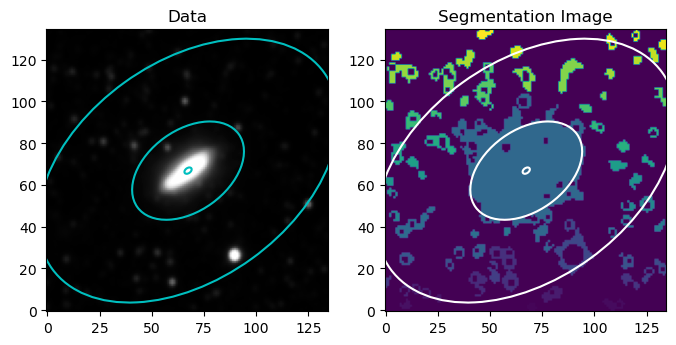

In [16]:
plotname='W3apertures.png'
e_obj.draw_phot_apertures(plotname=plotname)

/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


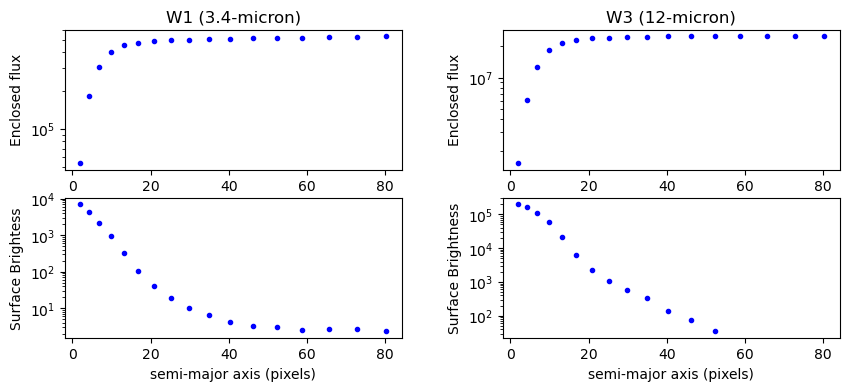

In [17]:
e_obj.plot_profiles(galaxyname='VFID0901')

---

## Automating the Process!

In [1]:
import sys
from astropy.table import Table
import os
homedir = os.getenv("HOME")
sys.path.append(homedir+'/github/wisesize/physical_sizes/')
from wisephot import wise_ellipse

In [2]:
print('Use: \n e_obj = ellipse(obj_catalog_path, w1_image_path, w3_image_path, w1_psf_path, w3_psf_path, mask_path=None, objra=None, objdec=None) \n e_obj.run_two_image_phot() \n e_obj.check_fitted_psf() \n e_obj.plot_profiles(ax_scale=log,savefig=False) \n e_obj.check_ptsources(box_size=5)')


Use: 
 e_obj = ellipse(obj_catalog_path, w1_image_path, w3_image_path, w1_psf_path, w3_psf_path, mask_path=None, objra=None, objdec=None) 
 e_obj.run_two_image_phot() 
 e_obj.check_fitted_psf() 
 e_obj.plot_profiles(ax_scale=log,savefig=False) 
 e_obj.check_ptsources(box_size=5)


#### VFID0901 (W3/W1 Re size ratio = 1.2947)

In [30]:
VFID = 'VFID0901'

#obj catalog
vf_path = homedir+'/Desktop/VF_WISESIZE.fits'
vf_cat = Table.read(homedir+'/Desktop/VF_WISESIZE.fits')

#objname
objname = vf_cat[vf_cat['VFID']==VFID]['prefix']
objname = objname[0].split('-')[1]

#WISE image path
w3_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-W3.fits'
w1_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-W1.fits'

#PSFs
w1_psf_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-psf-W1.fits'
w3_psf_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-psf-W3.fits'

#mask
wise_mask_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-wise-mask.fits'

objra = vf_cat['RA'][vf_cat['VFID']==VFID]
objdec = vf_cat['DEC'][vf_cat['VFID']==VFID]

In [31]:
e_obj = wise_ellipse(obj_catalog_path=vf_path, w1_image_path=w1_path, 
                     w3_image_path=w3_path, w1_psf_path=w1_psf_path, 
                     w3_psf_path=w3_psf_path, mask_path=wise_mask_path,
                     objra=objra, objdec=objdec)

STDDEV W3 --> x=1.345424838984275, y=1.1899060219384703
STDDEV W1 --> x=1.052871345640946, y=0.9213989211505152
FITTED PSF --> x=0.8376335277936799, y=0.7529278645050281


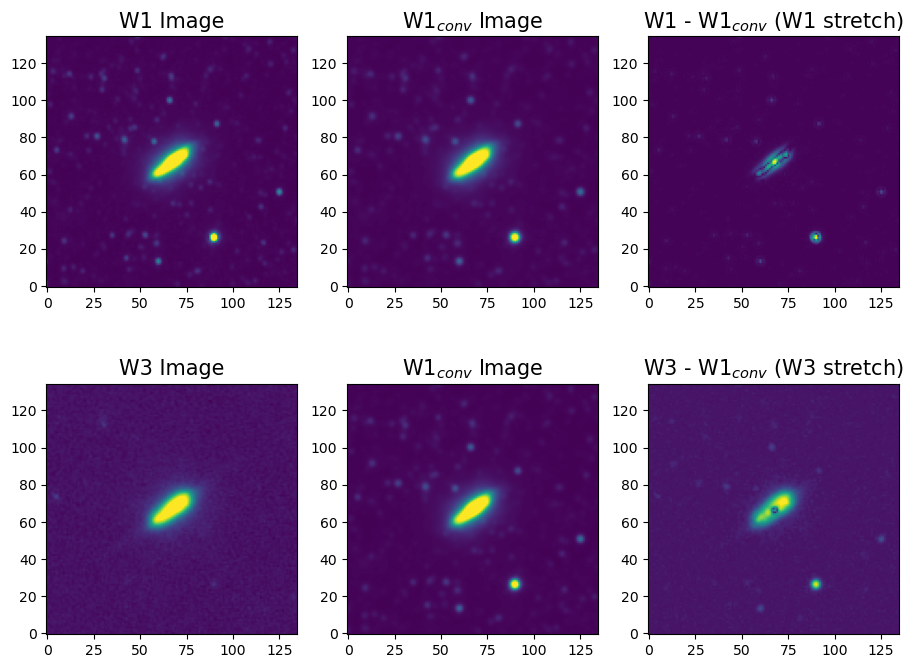

Number of apertures =  30


In [32]:
e_obj.run_two_image_phot(savefig=False)

/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


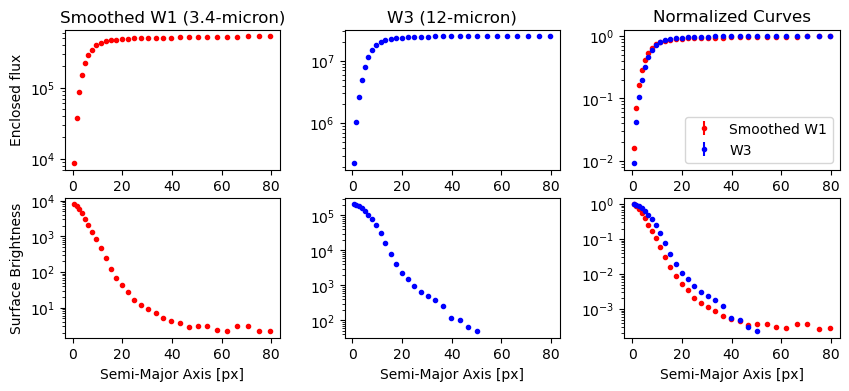

In [33]:
e_obj.plot_profiles(galaxyname=e_obj.galaxy_name)

photutils detected the following objects:
x_peak y_peak peak_value
------ ------ ----------
    90     26  3013.3513
    68     67   8277.936


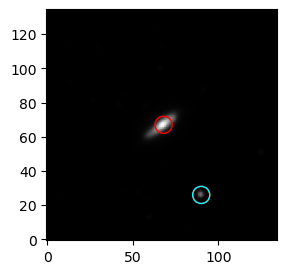

Number of apertures =  14


/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


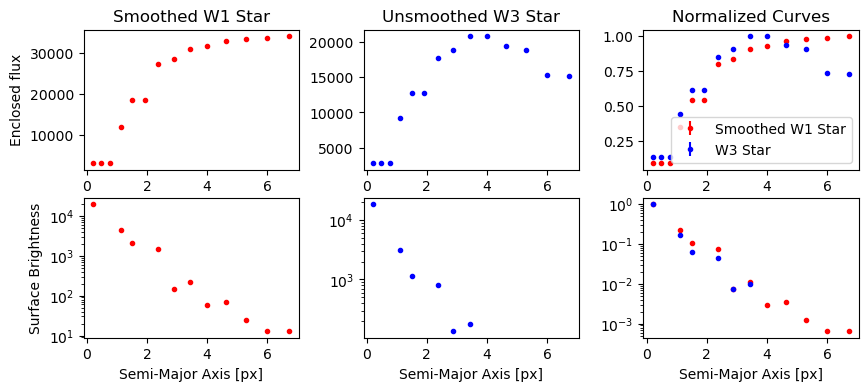

In [34]:
e_obj.check_ptsources()

#### VFID0941 (W3/W1 Re size ratio = 1.0750)

In [9]:
VFID = 'VFID0941'

#objname
objname = vf_cat[vf_cat['VFID']==VFID]['prefix']
objname = objname[0].split('-')[1]

#WISE image path
w3_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-W3.fits'
w1_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-W1.fits'

#PSFs
w1_psf_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-psf-W1.fits'
w3_psf_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-psf-W3.fits'

#mask
wise_mask_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-wise-mask.fits'

objra = vf_cat['RA'][vf_cat['VFID']==VFID]
objdec = vf_cat['DEC'][vf_cat['VFID']==VFID]

In [10]:
e_obj = wise_ellipse(obj_catalog_path=vf_path, w1_image_path=w1_path, 
                     w3_image_path=w3_path, w1_psf_path=w1_psf_path, 
                     w3_psf_path=w3_psf_path, mask_path=wise_mask_path,
                     objra=objra, objdec=objdec)

STDDEV W3 --> x=1.3454767989179501, y=1.189944246247144
STDDEV W1 --> x=1.0529155648089794, y=0.9214175975037792
FITTED PSF --> x=0.8376614052285577, y=0.7529654176567785


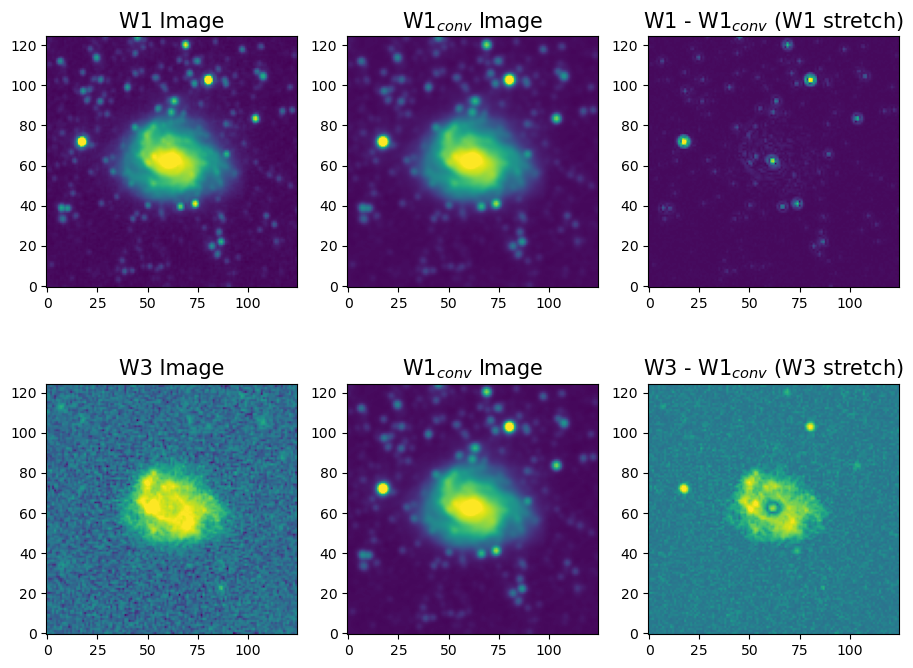

Number of apertures =  25


In [11]:
e_obj.run_two_image_phot()

/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


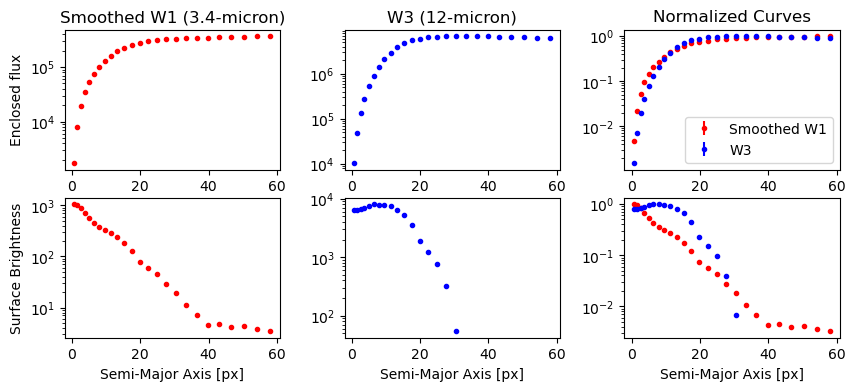

In [12]:
e_obj.plot_profiles(galaxyname=e_obj.galaxy_name)

photutils detected the following objects:
x_peak y_peak peak_value
------ ------ ----------
    62     62  1541.6754
    17     72  1819.2993
    80    103  1333.5209


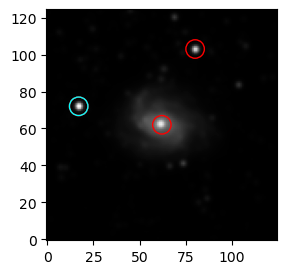

Number of apertures =  14


/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


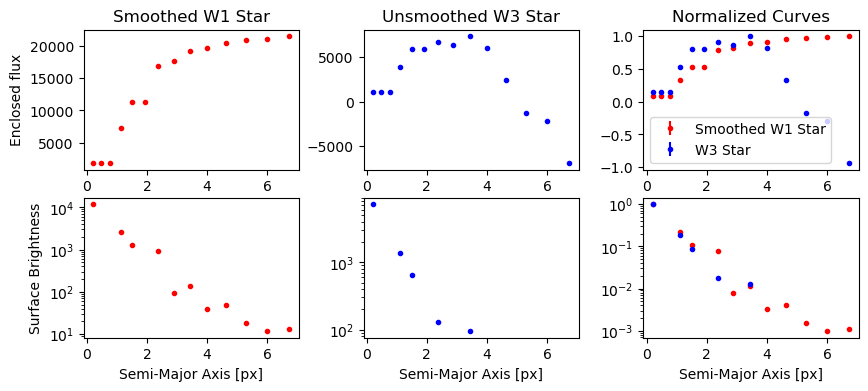

In [13]:
e_obj.check_ptsources()

#### VFID0959 (W3/W1 Re size ratio = 1.0908)

In [14]:
VFID = 'VFID0959'

#objname
objname = vf_cat[vf_cat['VFID']==VFID]['prefix']
objname = objname[0].split('-')[1]

#WISE image path
w3_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-W3.fits'
w1_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-W1.fits'

#PSFs
w1_psf_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-psf-W1.fits'
w3_psf_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-psf-W3.fits'

#mask
wise_mask_path = f'{homedir}/vf_html_w1/all_input_fits/{objname}-custom-image-wise-mask.fits'

objra = vf_cat['RA'][vf_cat['VFID']==VFID]
objdec = vf_cat['DEC'][vf_cat['VFID']==VFID]

In [15]:
e_obj = wise_ellipse(obj_catalog_path=vf_path, w1_image_path=w1_path, 
                     w3_image_path=w3_path, w1_psf_path=w1_psf_path, 
                     w3_psf_path=w3_psf_path, mask_path=wise_mask_path,
                     objra=objra, objdec=objdec)

STDDEV W3 --> x=1.3454767989179501, y=1.189944246247144
STDDEV W1 --> x=1.0529155648089794, y=0.9214175975037792
FITTED PSF --> x=0.8376614052285577, y=0.7529654176567785


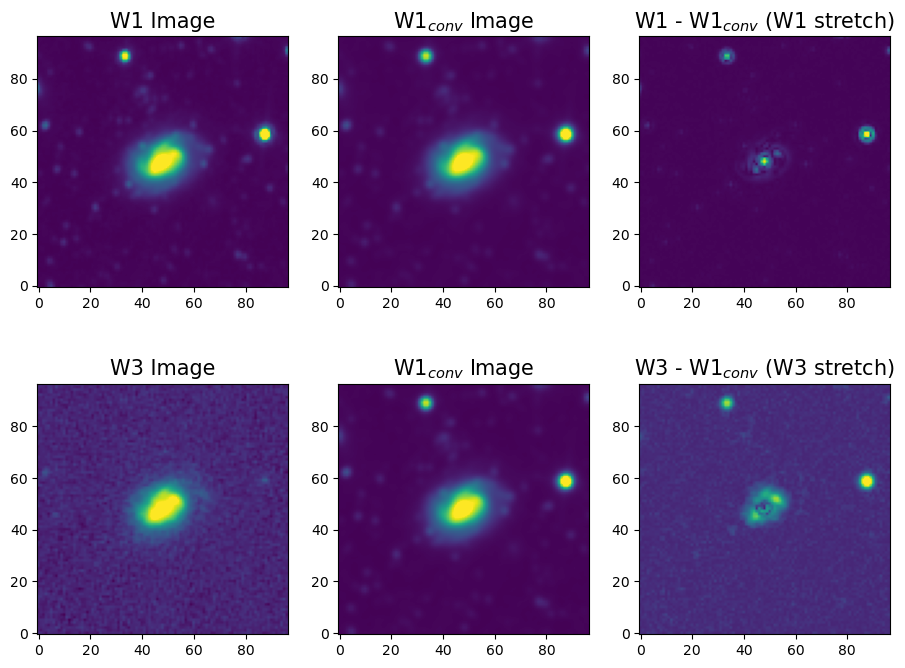

Number of apertures =  26


In [16]:
e_obj.run_two_image_phot()

/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


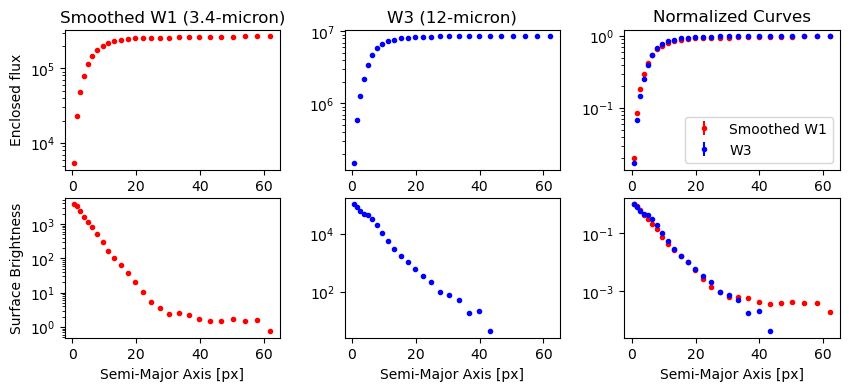

In [17]:
e_obj.plot_profiles(galaxyname=e_obj.galaxy_name)

photutils detected the following objects:
x_peak y_peak peak_value
------ ------ ----------
    48     48    4124.46
    88     59  3187.0996
    34     89  1096.6353


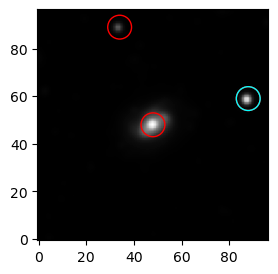

Number of apertures =  14


/Users/k215c316/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


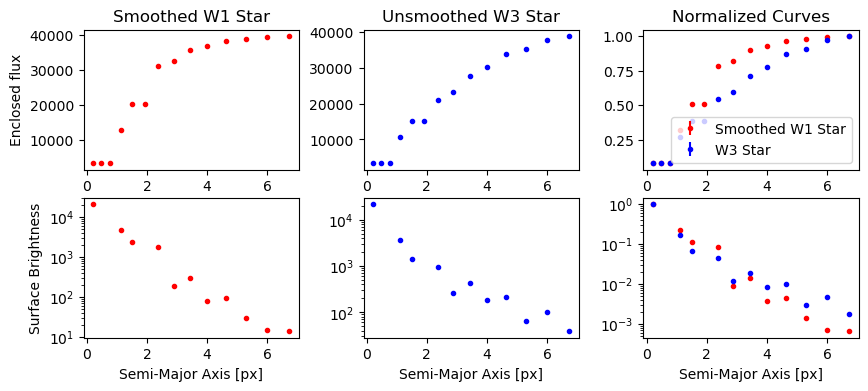

In [18]:
e_obj.check_ptsources()

-----

## Appendix

#### (a) Ellipse photometry on point sources in W3, smoothed W1 images

In [20]:
#this section demonstrates the general format of the point source photometry
#function in the ellipse class of wisephot.py

#note that rather than manually providing the central (x, y) coordinate for the 
#desired star, I have instead automated the process with photutils.detection.find_peaks
#for simplicity of this example, however, I simply input the coordinate for a star
#in the VFID0901 cutout's FOV. 

In [24]:
import numpy as np
import sys

from astropy.table import Table

from photutils.isophote import EllipseGeometry, Ellipse
from photutils.aperture import aperture_photometry, EllipticalAperture, CircularAperture

from matplotlib import pyplot as plt
%matplotlib inline

import os
homedir = os.getenv("HOME")

In [35]:
#VFID0901; star central x,y coordinates taken from DS9
x_star = 90
y_star = 26

In [36]:
#image variables, just taken from VFID0901 example above
smoothed_w1 = e_obj.smoothed_w1
w3_im = e_obj.w3_im

In [37]:
#def get_ellipse_guess(x_star, y_star):
    
position = (x_star, y_star) #same for both bands (same pixel scale and img dimensions)
sma = 3 #I approximated the prominent pixel SMA/radius in DS9 (using W1)
start_size = sma
b = start_size
eps = 0   #assume no ellipticity
theta = 0   #no angle/orientation

aperture = EllipticalAperture(position, sma, b, theta=theta)
guess = EllipseGeometry(x0=x_star,y0=y_star,sma=sma,eps=eps, pa=theta)

#def measure_phot():
    
#for central galaxy, rmax set according to image dimansions. for a noncentral point source,
#I just use some multiple of the sma
rmax = 2.5*sma

index = np.arange(80)
apertures = (index+1)*.2*(1+(index+1)*.1)
# cut off apertures at edge of image
apertures_a = apertures[apertures < rmax]
print('Number of apertures = ',len(apertures_a))
apertures_b = (1.-eps)*apertures_a   #will be the same since eps=0 for circle
area = np.pi*apertures_a*apertures_b    #area of each ellipse

#creating empty flux arrays
flux1 = np.zeros(len(apertures_a),'f')  
flux2 = np.zeros(len(apertures_a),'f')

allellipses = []

for i in range(len(apertures_a)):
    ap = EllipticalAperture(position,apertures_a[i],apertures_b[i],theta)
    allellipses.append(ap)
    
    # another problem -- central galaxy not masked out. oh well.
    #subpixel is the method that Source Extractor uses
    phot_table1 = aperture_photometry(smoothed_w1, ap, method = 'subpixel', subpixels=1)
    phot_table2 = aperture_photometry(w3_im, ap, method = 'subpixel', subpixels=1)
    
    flux1[i] = phot_table1['aperture_sum'][0]
    flux2[i] = phot_table2['aperture_sum'][0]

#def calc_sb():
# calculate surface brightness in each aperture

# first aperture is calculated differently
sb1 = np.zeros(len(apertures_a),'f')

sb1[0] = flux1[0]/area[0]
# outer apertures need flux from inner aperture subtracted
for i in range(1,len(area)):
    sb1[i] = (flux1[i] - flux1[i-1])/(area[i]-area[i-1])

sb2 = np.zeros(len(apertures_a),'f')
sb2[0] = flux2[0]/area[0]
for i in range(1,len(area)):
    sb2[i] = (flux2[i] - flux2[i-1])/(area[i]-area[i-1])

Number of apertures =  14


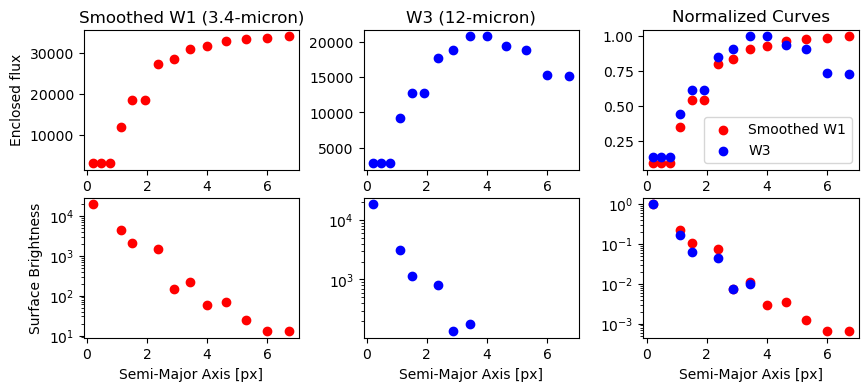

In [38]:
plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=.3)

plt.subplot(2,3,1)
plt.scatter(apertures_a,flux1,color='r')
plt.title('Smoothed W1 (3.4-micron)')
plt.ylabel('Enclosed flux')
#plt.gca().set_yscale('log')

plt.subplot(2,3,2)
plt.scatter(apertures_a,flux2,color='b')
plt.title('W3 (12-micron)')
#plt.gca().set_yscale('log')

plt.subplot(2,3,3)
plt.scatter(apertures_a, flux1/np.max(flux1), color='r',label='Smoothed W1')
plt.scatter(apertures_a, flux2/np.max(flux2), color='b',label='W3')
plt.title('Normalized Curves')
#plt.gca().set_yscale('log')
plt.legend()

plt.subplot(2,3,4)
plt.scatter(apertures_a,sb1,color='r')
plt.ylabel('Surface Brightness')
plt.xlabel('Semi-Major Axis [px]')
plt.gca().set_yscale('log')

plt.subplot(2,3,5)
plt.scatter(apertures_a,sb2,color='b')
plt.xlabel('Semi-Major Axis [px]')
plt.gca().set_yscale('log')

plt.subplot(2,3,6)
plt.scatter(apertures_a, sb1/np.max(sb1), color='r')
plt.scatter(apertures_a, sb2/np.max(sb2), color='b')
plt.gca().set_yscale('log')
plt.xlabel('Semi-Major Axis [px]')

plt.show()

(10.0, 40.0)

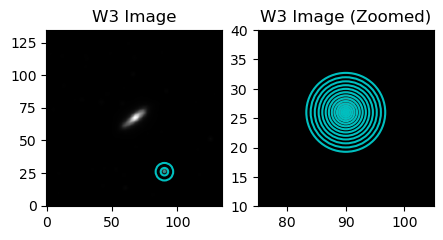

In [39]:
#display_image(self.image)
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(smoothed_w1, origin='lower', cmap='Greys_r')
plt.title('W3 Image')
# plot a subset of apertures
nap = len(allellipses)
plotaps = np.array([0,nap//2,-1],'i')
for i in plotaps:
    aperture = allellipses[i]
    aperture.plot(color='c', lw=1.5)
plt.subplot(1,2,2)
plt.imshow(smoothed_w1,origin='lower',cmap='Greys_r')
plt.title('W3 Image (Zoomed)')
# plot a subset of apertures
nap = len(allellipses)
plotaps = np.array([0,nap//2,-1],'i')
#for i in plotaps:
for i in range(nap):
    aperture = allellipses[i]
    aperture.plot(color='c', lw=1.5)
plt.xlim(75,105)
plt.ylim(10,40)